# Подготовка

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.seasonal import seasonal_decompose

import os

Выгружаем датасет

In [2]:
BASE_DIR = os.getcwd()

In [3]:
# INDEX_BTCUSD, 720 - 12h tf
df = pd.read_csv(f'{BASE_DIR}/datasets/BTC-USD(4).csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    4846 non-null   object 
 1   open    4846 non-null   float64
 2   high    4846 non-null   float64
 3   low     4846 non-null   float64
 4   close   4846 non-null   float64
dtypes: float64(4), object(1)
memory usage: 189.4+ KB


In [5]:
df['time'] = pd.to_datetime(df['time'])

In [6]:
df = df.set_index(df['time']).drop('time', axis=1)
df = df.drop(['open','high','low'], axis=1)
df = df.astype('float')

In [7]:
df_d = df[['close']]

<AxesSubplot:xlabel='time'>

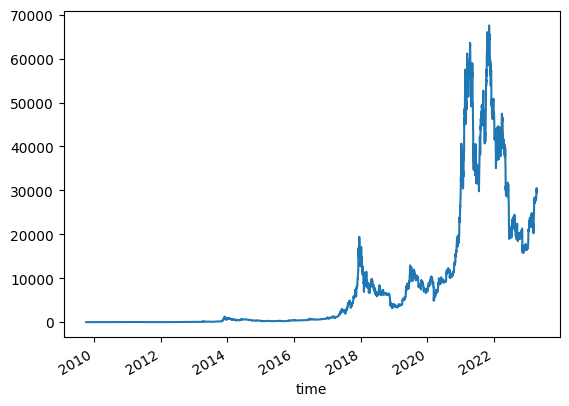

In [8]:
df_d['close'].plot(kind='line')

## Заменяем индексацию

Заменяем индексацию по времени на индексацию по блокам

In [9]:
blocks = pd.read_csv(f'{BASE_DIR}/datasets/GLASSNODE_BTC_BLOCKS, 1D.csv')
blocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5212 entries, 0 to 5211
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    5212 non-null   object
 1   open    5212 non-null   int64 
 2   high    5212 non-null   int64 
 3   low     5212 non-null   int64 
 4   close   5212 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 203.7+ KB


In [10]:
#удаляем лишние столбцы
blocks['time'] = pd.to_datetime(blocks['time'])
blocks = blocks.set_index(blocks['time']).drop('time', axis=1)
blocks = blocks.drop(['open','high','low'], axis=1)
blocks = blocks.astype('float')
blocks['close2'] = blocks['close']
blocks = blocks.drop(['close'], axis=1)

Объединяем цену и количество блоков по времени

In [11]:
df_b =df.join(blocks, how='inner')
df_b.rename(columns={'close2': 'time'}, inplace=True)
df_b

,close,time
time,,
2009-10-05 00:00:00+00:00,0.000764,24418.0
2009-10-06 00:00:00+00:00,0.000885,24461.0
2009-10-07 00:00:00+00:00,0.001050,24521.0
2009-10-08 00:00:00+00:00,0.001084,24591.0
2009-10-09 00:00:00+00:00,0.001200,24671.0
...,...,...
2023-04-13 00:00:00+00:00,30407.470000,785290.0
2023-04-14 00:00:00+00:00,30495.030000,785430.0
2023-04-15 00:00:00+00:00,30324.640000,785588.0


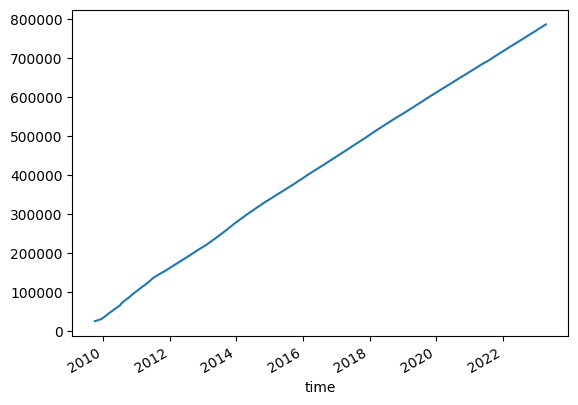

In [12]:
df_b['time'].plot(kind='line');

Меняем индексацию по времени на индексацию по блокам

In [13]:
df_b.set_index('time', inplace=True)

<AxesSubplot:xlabel='time'>

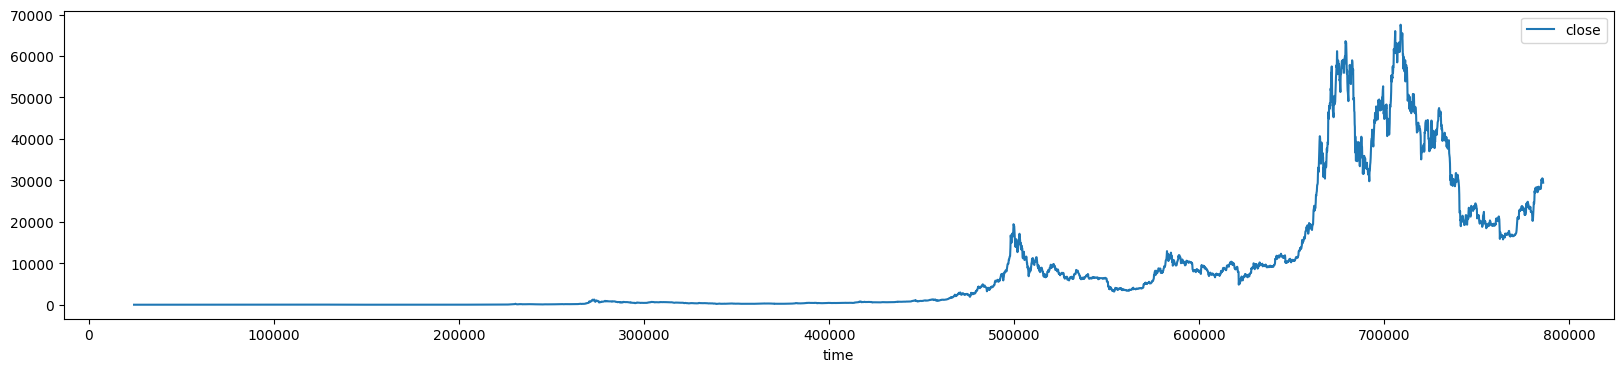

In [14]:
df_b.plot(kind='line', figsize = (20,4))

In [15]:
df_b

,close
time,
24418.0,0.000764
24461.0,0.000885
24521.0,0.001050
24591.0,0.001084
24671.0,0.001200
...,...
785290.0,30407.470000
785430.0,30495.030000
785588.0,30324.640000


## Метод Бокса-Кокса

In [16]:
from scipy import stats

In [17]:
df_box = pd.DataFrame(df_b.copy())
df_box['close'], box_cox_lambda = stats.boxcox(df_b['close'])

In [18]:
box_cox_lambda

0.13134561458013058

In [19]:
df_box

,close
time,
24418.0,-4.647397
24461.0,-4.589728
24521.0,-4.520697
24591.0,-4.507774
24671.0,-4.465977
...,...
785290.0,21.926072
785430.0,21.937231
785588.0,21.915491


<AxesSubplot:xlabel='time'>

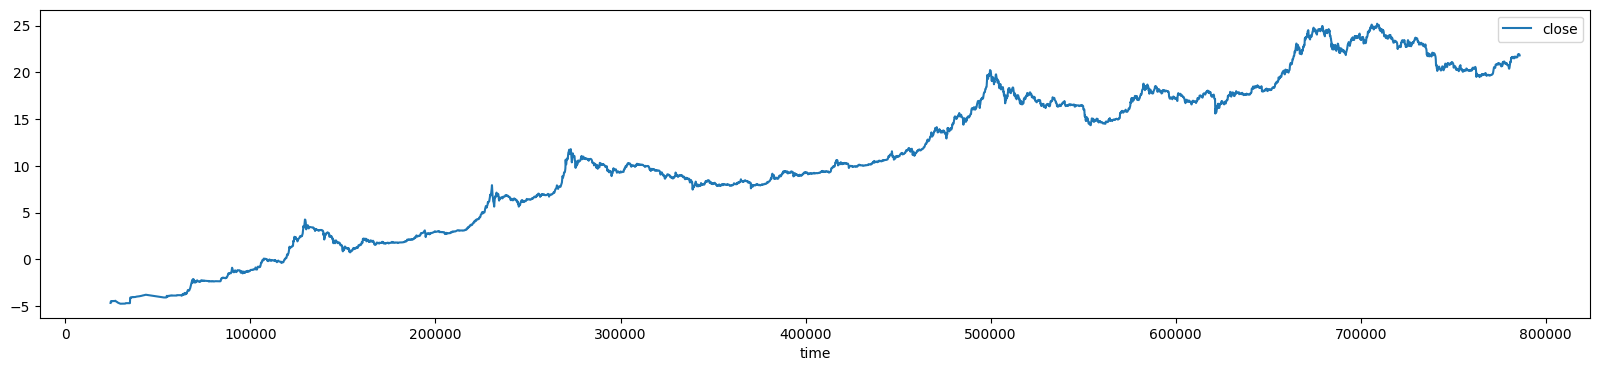

In [20]:
df_box.plot(kind='line', figsize = (20,4))

## LOWESS (Locally Weighted Scatterplot Smoothing)

Выделяем тренд вручную

In [21]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import adfuller

Подбираем frac чтобы в остатке был минимальные p-value в тесте Дики-Фуллера

In [22]:
pval = {}
"""
for i in range(60,101):
    trend = pd.DataFrame(lowess(df_wbox['close'], df_wbox.index, frac=i/100, it=3, return_sorted=False))
    # trend.plot(kind='line')
    trend.set_index(df_wbox.index, inplace=True)
    df_wbox_t = df_wbox.copy()
    df_wbox_t['close'] = (df_wbox['close'] - trend[0])
    # df_wbox_t.plot(kind='line')


    result = adfuller(df_wbox_t)
    # print('ADF Statistic:', result[0])
    # print('p-value:', result[1])
    # print('Critical Values:', result[4])
    print (i, result[1])
    if not result[1] is None:
        pval[i] = result[1]
        """


"\nfor i in range(60,101):\n    trend = pd.DataFrame(lowess(df_wbox['close'], df_wbox.index, frac=i/100, it=3, return_sorted=False))\n    # trend.plot(kind='line')\n    trend.set_index(df_wbox.index, inplace=True)\n    df_wbox_t = df_wbox.copy()\n    df_wbox_t['close'] = (df_wbox['close'] - trend[0])\n    # df_wbox_t.plot(kind='line')\n\n\n    result = adfuller(df_wbox_t)\n    # print('ADF Statistic:', result[0])\n    # print('p-value:', result[1])\n    # print('Critical Values:', result[4])\n    print (i, result[1])\n    if not result[1] is None:\n        pval[i] = result[1]\n        "

In [23]:
# min_val = min(pval.values())
# min_key = list(pval.keys())[list(pval.values()).index(min_val)]
# print(min_key)

ADF Statistic: -1.5885636163616357
p-value: 0.48933581534244625
Critical Values: {'1%': -3.4317096824174698, '5%': -2.862140827434085, '10%': -2.5670898220592187}


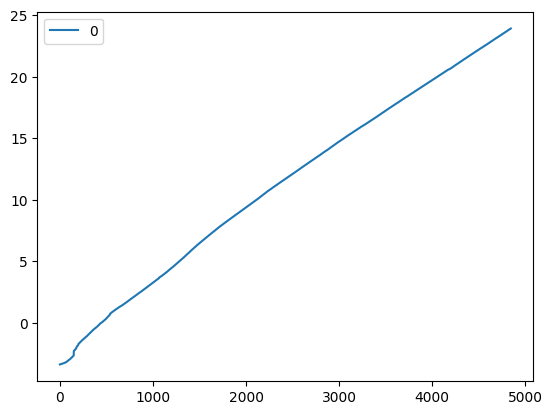

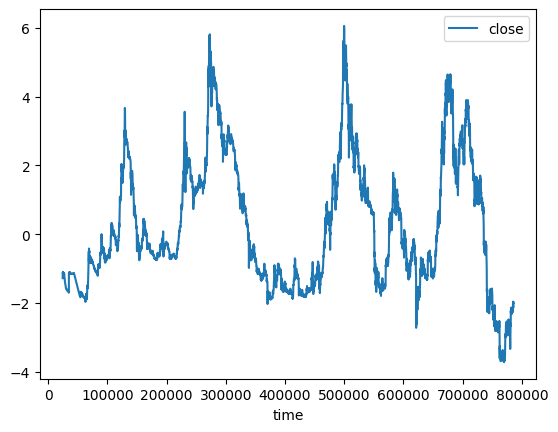

In [24]:
trend = pd.DataFrame(lowess(df_box['close'], df_box.index, frac=1, it=4, return_sorted=False))
trend.plot(kind='line')
trend.set_index(df_box.index, inplace=True)
df_cycle = df_box.copy()
df_cycle['close'] = (df_box['close'] - trend[0])
df_cycle.plot(kind='line')

result = adfuller(df_box)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

## Заполнение пропусков и изменение шага индексации

Можно увилеть что в начале много пропусков, т.к. отсутствует вся информация о количестве блоков в истории, пропуски необходимо заполнить. Используем метод bfill  
Также сейчас в качестве индекса ряд с неравномерным периодом, необходимо это исправить  

На данный момент история за 210000 * 3 + 155867 блоков  
Часть информации отсутствует в начале, часть блоков отсутствует в конце последнего цикла т.к. он ещё не завершился  
Чтобы сделать ряд равномерным сгруппируем данные по более крупному периоду, один шаг индексации будет равен 1000 блоков.

In [25]:
print(f'данные нужно разделить на {round((210000*3 + 155867)/1000)} бинов')

данные нужно разделить на 786 бинов


Обрезаем ряд до значения кратного 1000

In [26]:
df_cycle = df_cycle[0:785000]

Заполним пропуски после детренда ряда

In [27]:
# добавляем новую строку в начало датафрейма
new_row = pd.DataFrame({'close': [None], 'time': [0.0]})
new_row = new_row.set_index('time', drop=True)

df_cycle = pd.concat([new_row, df_cycle], axis=0)


<AxesSubplot:>

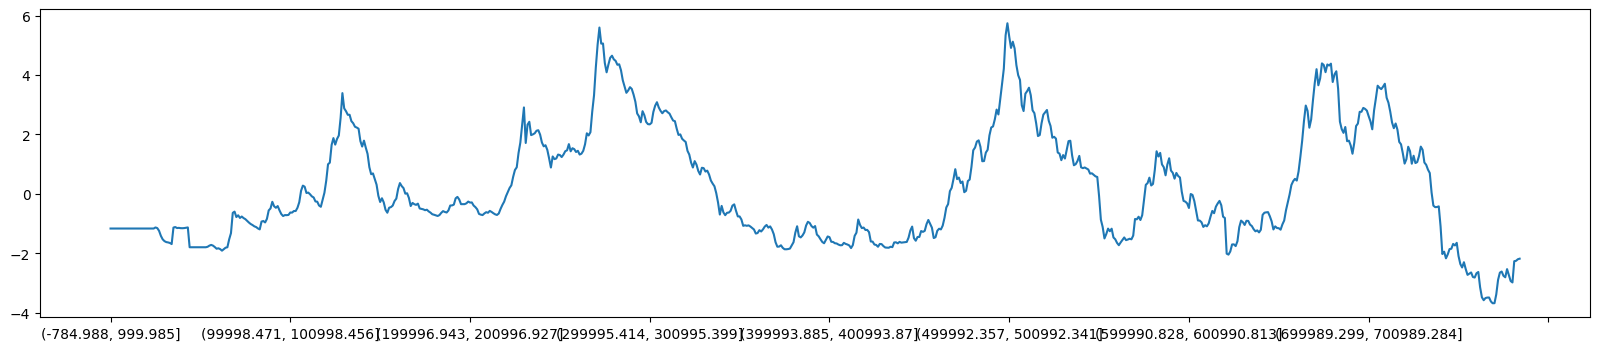

In [28]:
# Разбиваем индекс на батчи
batches = pd.cut(df_cycle.index, bins=round((785000)/1000))

# Группируем значения по батчам и применяем агрегирующую функцию mean
grouped = df_cycle.groupby(batches)['close'].mean()

#Один шаг индекса соответствует 100 блоков
#Заполняем пропуски в начале
grouped = grouped.fillna(method='bfill')
grouped.plot(kind='line', figsize = (20,4))

In [29]:
# сбрасываем индексы
df_g = grouped.reset_index(drop=True)
df_g

0     -1.164669
1     -1.164669
2     -1.164669
3     -1.164669
4     -1.164669
         ...   
780   -2.978572
781   -2.264238
782   -2.250962
783   -2.198565
784   -2.179358
Name: close, Length: 785, dtype: float64

## Автокорреляция

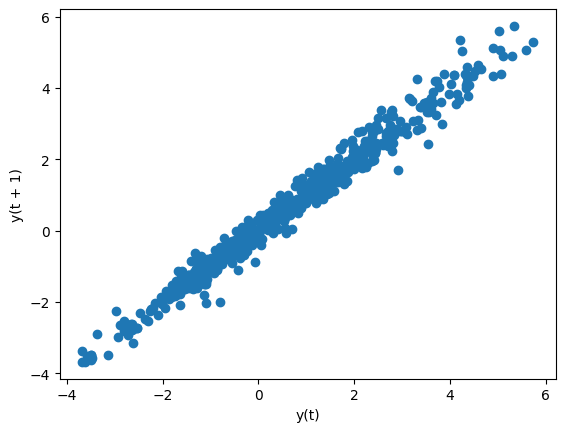

In [30]:
from matplotlib import pyplot
from pandas.plotting import lag_plot
lag_plot(df_g,1)
pyplot.show()

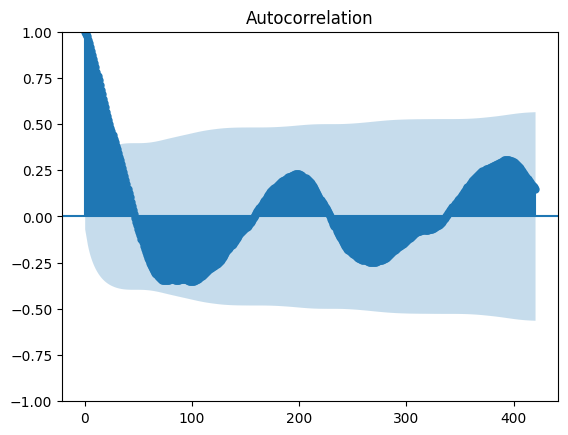

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_g, lags=420)
pyplot.show()

c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


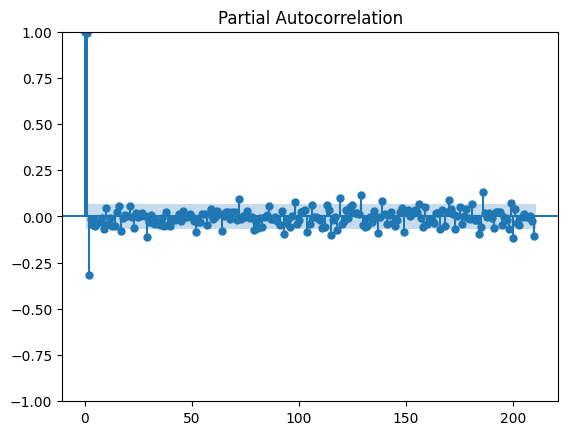

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_g, lags=210)
pyplot.show()

## Определение цикличности с плавающим периодом

Разделим временной на каждом 210 000 блоке, в момент халвинга

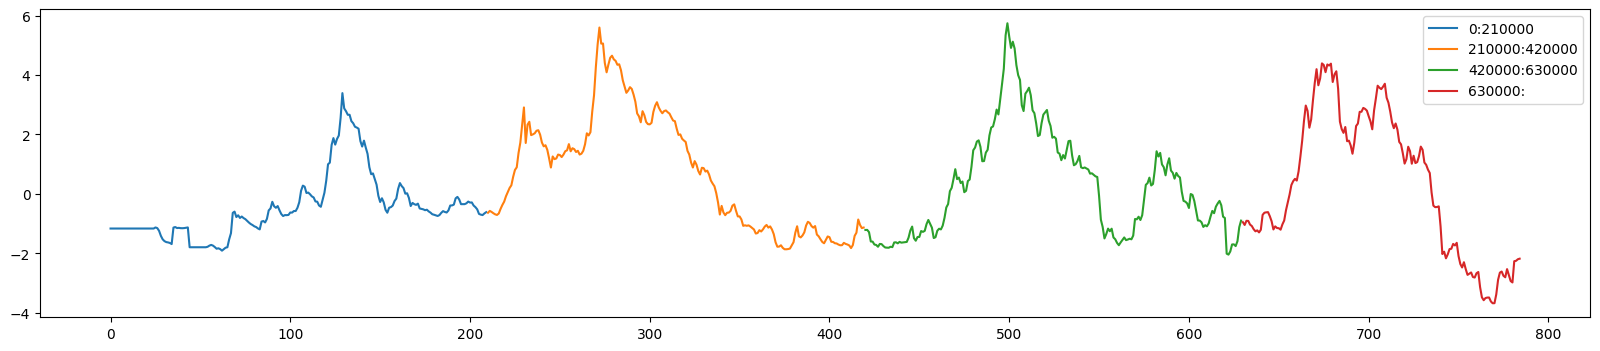

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_g[0:210].plot(kind='line', ax=ax, figsize = (20,4))
df_g[210:420].plot(kind='line', ax=ax, figsize = (20,4))
df_g[420:630].plot(kind='line', ax=ax, figsize = (20,4))
df_g[630:].plot(kind='line', ax=ax, figsize = (20,4))

# добавляем легенду
ax.legend(['0:210000', '210000:420000', '420000:630000', '630000:'])
plt.show()


In [34]:
# разделяем выборку и вычитаем начальную дату и время из индекса каждого периода
df_t1 = df_g[0:210]
df_t1.index = df_t1.index
df_t2 = df_g[210:420]
df_t2.index = df_t2.index - 210
df_t3 = df_g[420:630]
df_t3.index = df_t3.index - 420
df_t4 = df_g[630:]
df_t4.index = df_t4.index - 630

In [35]:
df_all = pd.DataFrame(df_t1.copy())
# делим значения первого цикла пополам чтобы уменьшить влияние на среднее
df_all['close'] = df_all['close']/2
df_all['close2'] = df_t2
df_all['close3'] = df_t3
df_all['close4'] = df_t4

In [36]:
df_all

,close,close2,close3,close4
0,-0.582335,-0.634258,-1.213243,-0.949811
1,-0.582335,-0.571527,-1.210654,-1.045119
2,-0.582335,-0.606564,-1.286938,-0.905086
3,-0.582335,-0.649998,-1.601156,-0.908735
4,-0.582335,-0.687536,-1.605404,-1.032436
...,...,...,...,...
205,-0.336471,-1.304831,-1.697292,NaN
206,-0.348789,-0.861561,-1.755321,NaN
207,-0.355910,-1.043326,-1.589337,NaN
208,-0.328629,-1.149973,-1.119203,NaN


In [37]:
df_mean = df_all.fillna(method='ffill').mean(axis=1)

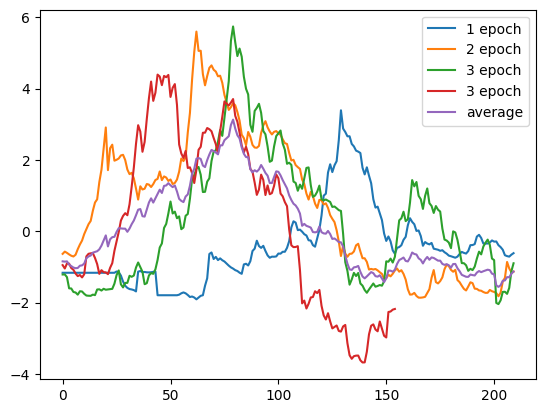

In [38]:

# создаем объект Axes
fig, ax = plt.subplots()

# наложение графиков на один график
df_t1.plot(kind='line', ax=ax)
df_t2.plot(kind='line', ax=ax)
df_t3.plot(kind='line', ax=ax)
df_t4.plot(kind='line', ax=ax)
df_mean.plot(kind='line', ax=ax)

# добавление легенды
ax.legend(['1 epoch', '2 epoch', '3 epoch', '3 epoch','average'])

# показать график
plt.show()


<AxesSubplot:>

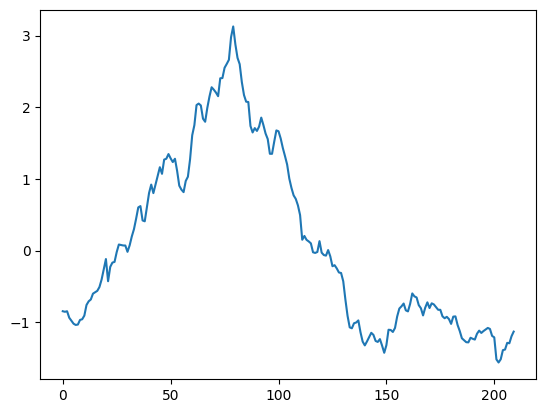

In [39]:
df_mean.plot(kind='line')

## DTW (Dynamic Time Wraping)

In [40]:
!pip install tslearn

In [41]:
df_full = df_all.fillna(method='ffill')

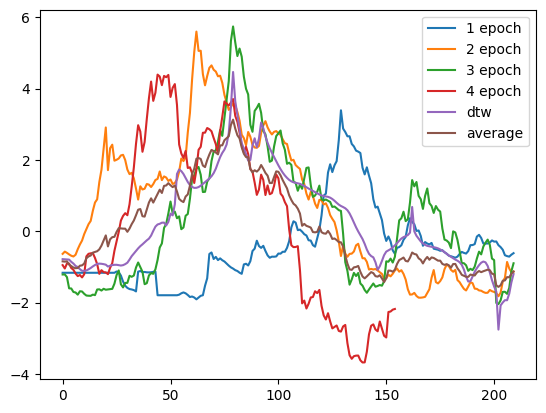

In [74]:
from tslearn.barycenters import softdtw_barycenter

# dtw = softdtw_barycenter(df_full, gamma=1., max_iter=50, tol=1e-3)
dtw = (softdtw_barycenter(df_full.transpose(), gamma=1, max_iter=500, tol=1e-3))
df_dtw = pd.DataFrame(dtw)

# создаем объект Axes
fig, ax = plt.subplots()

# наложение графиков на один график
df_t1.plot(kind='line', ax=ax)
df_t2.plot(kind='line', ax=ax)
df_t3.plot(kind='line', ax=ax)
df_t4.plot(kind='line', ax=ax)
df_dtw.plot(kind='line', ax=ax)
df_mean.plot(kind='line', ax=ax)

# добавление легенды
ax.legend([
    '1 epoch', 
    '2 epoch', 
    '3 epoch', 
    '4 epoch', 
    'dtw',
    'average',
])

# показать график
plt.show()


<AxesSubplot:>

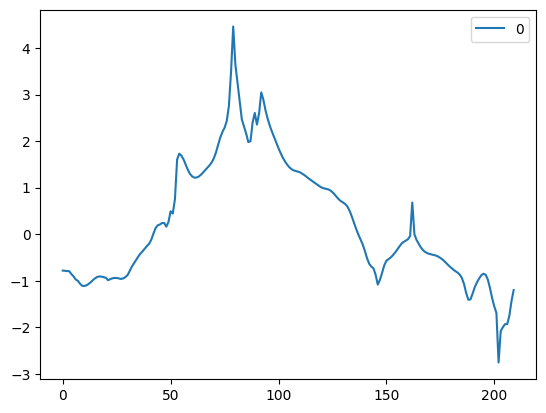

In [93]:
df_dtw.plot(kind='line')

Продублируем циклы и вычтем из временного ряда с детрендом

In [44]:
df_mean_full = np.tile(df_mean, 4)

In [45]:
df_mean_full

array([-0.84491183, -0.85240895, -0.84523066, -0.93555578, -0.97692768,
       -1.01882141, -1.03634849, -1.03076459, -0.96616801, -0.95710614,
       -0.90599057, -0.75811243, -0.70674427, -0.68107103, -0.59980673,
       -0.57969668, -0.56055624, -0.50731672, -0.40265714, -0.25630342,
       -0.11695434, -0.42612211, -0.22647072, -0.16669069, -0.15639114,
       -0.01984404,  0.08588778,  0.07845297,  0.07257111,  0.07183132,
       -0.0160056 ,  0.07430709,  0.19857064,  0.30028874,  0.44637831,
        0.60409172,  0.62190431,  0.42190679,  0.40968229,  0.6088741 ,
        0.8052063 ,  0.92201672,  0.80306833,  0.9220577 ,  1.03862439,
        1.16456355,  1.0722161 ,  1.2710876 ,  1.28282821,  1.34815943,
        1.28780649,  1.23646248,  1.28250311,  1.113696  ,  0.90695794,
        0.85135322,  0.81680915,  0.97270828,  1.03199403,  1.27435374,
        1.61043193,  1.75141318,  2.0316665 ,  2.05254709,  2.02604349,
        1.84156337,  1.79874159,  1.9934332 ,  2.15100664,  2.28

<AxesSubplot:>

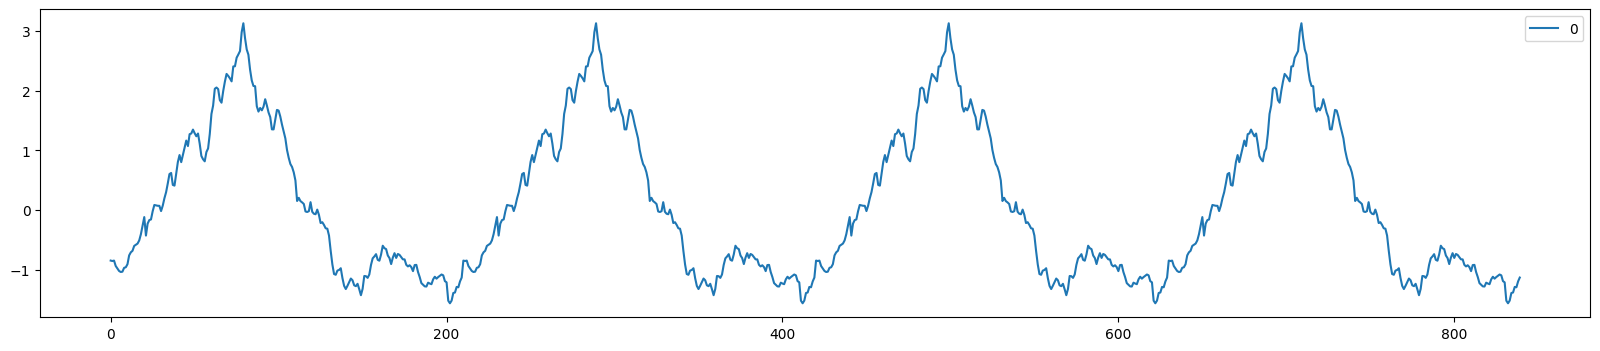

In [46]:
df_mean_full = pd.DataFrame(df_mean_full)[:785000]
df_mean_full.plot(kind = 'line', figsize = (20,4))

Вычтем сезоны

In [47]:
df_mean_full = df_mean_full.rename(columns={0: 'close'})

In [48]:
df_residual = pd.DataFrame(df_g) - df_mean_full
df_residual = df_residual.dropna()

<AxesSubplot:>

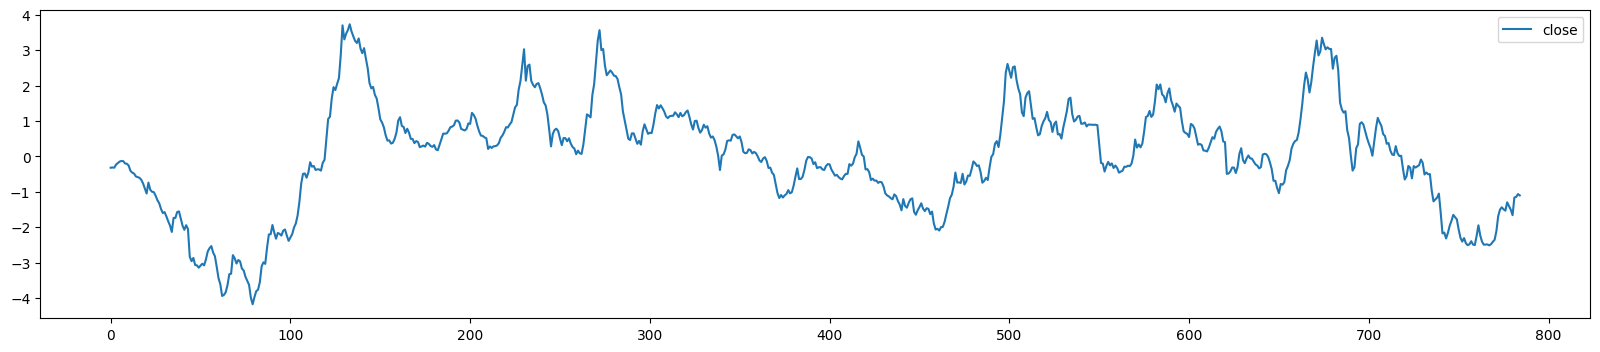

In [49]:
df_residual.plot(kind='line', figsize = (20,4))

In [50]:
# decomposed = seasonal_decompose(df_residual['close'])
# decomposed.trend.plot()
# from statsmodels.tsa.seasonal import STL
# stl_kwargs = {"seasonal_deg": 0} 
# model = STL(df_residual, trend_jump=1000, period=48)
# res = model.fit()
# res.plot()
# decomposed.seasonal.plot()
# decomposed.resid.plot()